**Scenario 3:Increase in freight cost by 30% due to container shortage**

In [96]:
#Increase in freight cost due to container shortage
import pandas as pd
from pulp import *

In [98]:
var_costs = pd.read_excel("variable_costs.xlsx", index_col = 0)
var_costs


,NY,NJ,PA,MA,NH
Variable Costs ($/Unit),,,,,
NY,12,12,12,12,12
NJ,9,9,9,9,9
PA,11,11,11,11,11
MA,10,10,10,10,10
NH,8,8,8,8,8


In [100]:
modified_freight_costs = pd.read_excel("modified_freight_costs.xlsx", index_col = 0)
modified_freight_costs


,NY,NJ,PA,MA,NH
Freight Costs ($/Container),,,,,
NY,0,15925,1430,20930,11411
NJ,17335,0,11202,26317,13094
PA,20020,29575,0,56693,18655
MA,21385,28665,36400,0,38675
NH,17745,20020,31850,38220,0


In [102]:
stor_costs = pd.read_excel("Storage_costs.xlsx", index_col = 0)
stor_costs

,Low,High
Storage Costs ($/unit),,
NY,43.333333,63.333333
NJ,21.533333,31.533333
PA,41.533333,60.666667
MA,33.200000,48.466667
NH,14.066667,41.066667


In [104]:
carb_emissions = pd.read_excel("CO2_Emissions.xlsx", index_col = 0)
carb_emissions

,NY,NJ,PA,MA,NH
CO2 Emissions (kgs),,,,,
NY,0.000,5.774,7.950,17.155,22.092
NJ,5.774,0.000,19.498,22.678,28.201
PA,7.950,19.498,0.000,31.297,36.653
MA,17.155,22.678,31.297,0.000,6.276
NH,22.092,28.201,36.653,6.276,0.000


In [106]:
lead_time = pd.read_excel("Delivery_LeadTime.xlsx", index_col = 0)
lead_time

,NY,NJ,PA,MA,NH
NY,1,3,9,3,6
NJ,3,1,12,3,9
PA,9,12,1,15,21
MA,3,3,15,1,6
NH,6,9,21,6,1


In [108]:
total_costs = modified_freight_costs/1000 + var_costs 
total_costs

,NY,NJ,PA,MA,NH
Freight Costs ($/Container),,,,,
NY,12.000,27.925,13.430,32.930,23.411
NJ,26.335,9.000,20.202,35.317,22.094
PA,31.020,40.575,11.000,67.693,29.655
MA,31.385,38.665,46.400,10.000,48.675
NH,25.745,28.020,39.850,46.220,8.000


In [110]:
fixed_costs = pd.read_excel("fixed_cost.xlsx",index_col = 0)
fixed_costs

,Low,High
NY,6500,9500
NJ,3230,4730
PA,6230,9100
MA,4980,7270
NH,2110,6160


In [112]:
fixed_costs = pd.read_excel("fixed_cost.xlsx", index_col = 0)
fixed_costs

,Low,High
NY,6500,9500
NJ,3230,4730
PA,6230,9100
MA,4980,7270
NH,2110,6160


In [114]:
total_fixed = fixed_costs + stor_costs
total_fixed

,Low,High
NY,6543.333333,9563.333333
NJ,3251.533333,4761.533333
PA,6271.533333,9160.666667
MA,5013.200000,7318.466667
NH,2124.066667,6201.066667


In [116]:
delivery_times = pd.read_excel("Delivery_LeadTime.xlsx", index_col = 0)
delivery_times

,NY,NJ,PA,MA,NH
NY,1,3,9,3,6
NJ,3,1,12,3,9
PA,9,12,1,15,21
MA,3,3,15,1,6
NH,6,9,21,6,1


In [118]:
cap = pd.read_excel("capacity.xlsx", index_col = 0)
cap

,Low,High
Capacity (kUnits/month),,
NY,500,1000
NJ,500,1000
PA,500,1000
MA,500,1000
NH,500,1000


In [120]:
demand = pd.read_excel("demand.xlsx", index_col = 0)
demand

,Demand
(Units/month),
NY,2800000
NJ,90000
PA,1700000
MA,145000
NH,160000


In [122]:
Co2_dict = {'NY':10000000000,'NJ':10000000000,'PA':10000000000,'MA':10000000000,'NH':10000000000}
Co2_dict
Co2_Limits  = pd.DataFrame(Co2_dict.items(), columns = ['Country', 'Max CO2 permitted (in kgs)'], )
Co2_Limits.set_index('Country')

,Max CO2 permitted (in kgs)
Country,
NY,10000000000
NJ,10000000000
PA,10000000000
MA,10000000000
NH,10000000000


In [124]:
del_deadline = pd.read_excel("Delivery_Deadlines.xlsx", index_col = 0)
del_deadline

,NY,NJ,PA,MA,NH
NY,30,30,30,30,30
NJ,30,30,30,30,30
PA,30,30,30,30,30
MA,30,30,30,30,30
NH,30,30,30,30,30


In [126]:
# Define Decision Variables through a list
loc = ['NY', 'NJ', 'PA', 'MA', 'NH']
size = ['Low', 'High']

# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)


# Create Decision Variables
x = LpVariable.dicts("production_", [(i,j) for i in loc for j in loc],
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_", 
                     [(i,s) for s in size for i in loc], cat='Binary')
z = LpVariable.dicts("delivery_",[(i,j) for i in loc for j in loc], cat = 'Binary')

# Define Objective Function
model += (lpSum([total_fixed.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([total_costs.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000 for s in size])   
for j in loc:
    model += lpSum([carb_emissions.loc[i,j] * x[(i,j)] for i in loc]) <= [5000000000,5000000000,5000000000,5000000000,5000000000]  
    
model += lpSum([delivery_times.loc[i,j] * z[(i,j)] for i in loc for j in loc]) <= (del_deadline.loc[i,j] for i in loc for j in loc)

                                                           
                                                       
# Solve Model
model.solve()
print("Total Costs = {:,} ($/Month)".format(int(value(model.objective))))
print('\n' + "Status: {}".format(LpStatus[model.status]))


# Dictionary to display the output data after optimization:
dict_plant = {}
dict_prod = {}
for v in model.variables():
    if 'plant' in v.name:
        name = v.name.replace('plant__', '').replace('_', '')
        dict_plant[name] = int(v.varValue)
        p_name = name
    else:
        name = v.name.replace('production__', '').replace('_', '')
        dict_prod[name] = v.varValue
    print(name, "=", v.varValue)

Total Costs = 120,815,466 ($/Month)

Status: Optimal
delivery('MA','MA') = 0.0
delivery('MA','NH') = 0.0
delivery('MA','NJ') = 0.0
delivery('MA','NY') = 0.0
delivery('MA','PA') = 0.0
delivery('NH','MA') = 0.0
delivery('NH','NH') = 0.0
delivery('NH','NJ') = 0.0
delivery('NH','NY') = 0.0
delivery('NH','PA') = 0.0
delivery('NJ','MA') = 0.0
delivery('NJ','NH') = 0.0
delivery('NJ','NJ') = 0.0
delivery('NJ','NY') = 0.0
delivery('NJ','PA') = 0.0
delivery('NY','MA') = 0.0
delivery('NY','NH') = 0.0
delivery('NY','NJ') = 0.0
delivery('NY','NY') = 0.0
delivery('NY','PA') = 0.0
delivery('PA','MA') = 0.0
delivery('PA','NH') = 0.0
delivery('PA','NJ') = 0.0
delivery('PA','NY') = 0.0
delivery('PA','PA') = 0.0
('MA','High') = 0.0
('MA','Low') = 1.0
('NH','High') = 0.0
('NH','Low') = 1.0
('NJ','High') = 1.0
('NJ','Low') = 0.0
('NY','High') = 1.0
('NY','Low') = 1.0
('PA','High') = 1.0
('PA','Low') = 1.0
('MA','MA') = 145000.0
('MA','NH') = 0.0
('MA','NJ') = 0.0
('MA','NY') = 250000.0
('MA','PA') = 0.0
('

C:\Users\User\anaconda3\Lib\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [128]:
list_low, list_high = [], []
for l in loc:
    for cap in ['Low', 'High']:
        x = "('{}','{}')".format(l, cap)
        if cap == 'Low':
            list_low.append(dict_plant[x])
        else:
            list_high.append(dict_plant[x])
df_capacity = pd.DataFrame({'Location': loc, 'Low': list_low, 'High': list_high}).set_index('Location')
    
df_capacity

,Low,High
Location,,
NY,1,1
NJ,0,1
PA,1,1
MA,1,0
NH,1,0


In [130]:
# This section creates a 2D array like structure of the cotents of df_production
NY_List, NJ_List, PA_List, MA_List, NH_List = [], [], [], [], [] 
for l in loc:
    for var_costs in ['NY', 'NJ', 'PA', 'MA', 'NH']:
        x = "('{}','{}')".format(l, var_costs)
        if var_costs == 'NY':
            NY_List.append(dict_prod[x])
        elif var_costs == 'NJ':
            NJ_List.append(dict_prod[x])
        elif var_costs == 'PA':
            PA_List.append(dict_prod[x])
        elif var_costs == 'MA':
            MA_List.append(dict_prod[x])
        elif var_costs == 'NH':
            NH_List.append(dict_prod[x])

df_production = pd.DataFrame({'Location': loc, 'NY': NY_List, 'NJ': NJ_List, 'PA': PA_List, 'MA': MA_List, 'NH': NH_List}).set_index('Location')

df_production

,NY,NJ,PA,MA,NH
Location,,,,,
NY,1500000.0,0.0,0.0,0.0,0.0
NJ,710000.0,90000.0,200000.0,0.0,0.0
PA,0.0,0.0,1500000.0,0.0,0.0
MA,250000.0,0.0,0.0,145000.0,0.0
NH,340000.0,0.0,0.0,0.0,160000.0


In [132]:
df_production["Sum"] = df_production.sum(axis=1) #Calculates the total sum for each row i.e. for each state
df_production

,NY,NJ,PA,MA,NH,Sum
Location,,,,,,
NY,1500000.0,0.0,0.0,0.0,0.0,1500000.0
NJ,710000.0,90000.0,200000.0,0.0,0.0,1000000.0
PA,0.0,0.0,1500000.0,0.0,0.0,1500000.0
MA,250000.0,0.0,0.0,145000.0,0.0,395000.0
NH,340000.0,0.0,0.0,0.0,160000.0,500000.0


In [134]:
sum_list = df_production['Sum'] #displays the total cost adjacent to the state
sum_list

Location
NY    1500000.0
NJ    1000000.0
PA    1500000.0
MA     395000.0
NH     500000.0
Name: Sum, dtype: float64

In [136]:
#Including the limiting capacity for each poduction unit
low_prod, high_prod = [], []
for i,j,k in zip(list_low, list_high, sum_list):
    if i ==0 and j==1:
        high_prod.append(k)
        low_prod.append(0)
    elif i==1 and j==0:
        low_prod.append(k)
        high_prod.append(0)
    elif i==1 and j==1:
        low_prod.append(500000)
        high_prod.append(k-500000)
    else:
        low_prod.append(0)
        high_prod.append(0)
df_plot = pd.DataFrame({'Location': loc, 'Low': low_prod, 'High': high_prod})
df_plot

,Location,Low,High
0,NY,500000.0,1000000.0
1,NJ,0.0,1000000.0
2,PA,500000.0,1000000.0
3,MA,395000.0,0.0
4,NH,500000.0,0.0


In [138]:
dict_plot1 = {'Location':['NY','NJ','PA','MA','NH'], 'Low':[500000,0,500000,395000,500000],'High':[1000000,1000000,1000000,0,0]}
df_plot1 = pd.DataFrame(dict_plot1)
df_plot1

,Location,Low,High
0,NY,500000,1000000
1,NJ,0,1000000
2,PA,500000,1000000
3,MA,395000,0
4,NH,500000,0


In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

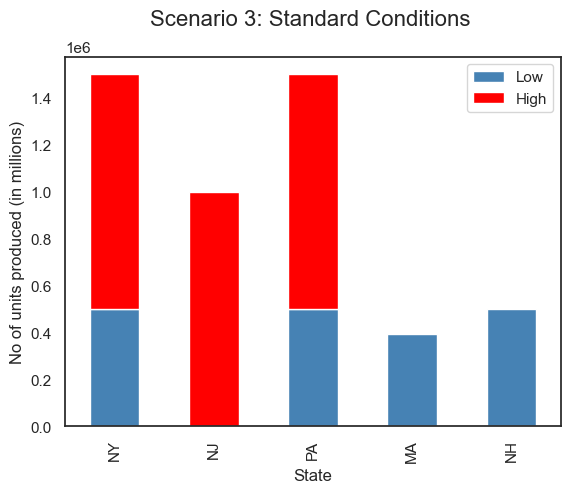

In [146]:
plot_list = []
sns.set(style = 'white')
scen_3 = df_plot1.set_index('Location').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
plt.title('Scenario 3: Standard Conditions \n', fontsize = 16)
plt.xlabel('State')
plt.ylabel('No of units produced (in millions)')
scen_3
plot_list.append(scen_3)